In [ ]:
@dataclass
class ChannelOutput:
    """
    Holds the processed channel data, separated into continuous and constant readouts.

    Attributes:
        continuous (pd.DataFrame): DataFrame with channels that have continuous data series.
                                   The index is a common set of x-values.
        constant (pd.DataFrame): DataFrame with channels that have single, constant values.
    """

    continuous: pd.DataFrame
    constant: pd.DataFrame

    def channels(self):
        """
        Returns a list of all channel names (both continuous and constant).
        """
        return [*self.continuous.columns.tolist(), *self.constant.columns.tolist()]

    def plot(self, ai_channels: list[AI] = None):
        """
        Generates and displays plots for the continuous and constant channel data.

        Parameters:
            ai_channels (list[AI], optional): A list of specific channel names to plot.
                                              If None, all channels are plotted.
        """
        continuous_to_plot = self.continuous
        constant_to_plot = self.constant

        # If a list of channels is provided, filter the dataframes
        if ai_channels:
            continuous_cols = [
                ch for ch in ai_channels if ch in self.continuous.columns
            ]
            continuous_to_plot = (
                self.continuous[continuous_cols] if continuous_cols else pd.DataFrame()
            )

            constant_cols = [ch for ch in ai_channels if ch in self.constant.columns]
            constant_to_plot = (
                self.constant[constant_cols] if constant_cols else pd.DataFrame()
            )

        # --- Plot Continuous Data ---
        if not continuous_to_plot.empty:
            # Semantic Grouping
            group_keywords = {
                "Izero_AI": ["AI"],
                "Signal": ["TEY", "Photodiode", "Izero"],
                "BeamStop": ["BeamStop"],
            }

            def get_group_key(chan_name):
                for key, keywords in group_keywords.items():
                    if any(keyword in chan_name for keyword in keywords):
                        return key
                return "Other"

            grouped_cols = {}
            for col in continuous_to_plot.columns:
                key = get_group_key(col)
                if key not in grouped_cols:
                    grouped_cols[key] = []
                grouped_cols[key].append(col)

            n_plots = len(grouped_cols)
            fig, axes = plt.subplots(n_plots, 1, figsize=(10, 3 * n_plots), sharex=True)
            if n_plots == 1:
                axes = [axes]

            for ax, (group_name, cols) in zip(axes, grouped_cols.items()):
                continuous_to_plot[cols].plot(ax=ax, linewidth=1.5)
                ax.set_ylabel("Data")
                ax.legend(
                    loc="upper center",
                    fontsize="medium",
                    ncols=min(len(cols), 5),
                    bbox_to_anchor=(0.5, 1.4),
                    handlelength=0.5,
                )
                ax.grid(True, alpha=0.4)

            fig.tight_layout(rect=[0, 0.03, 1, 0.98])
            plt.show()
        else:
            print("No continuous data to plot for the selected channels.")

        # --- Display Constant Data ---
        if not constant_to_plot.empty:
            print("Constant Channel Values:")
            display(constant_to_plot)
        else:
            print("No constant data to display for the selected channels.")


def process_channels(data_dict: dict) -> ChannelOutput:
    """
    Processes raw channel data from a dictionary into a ChannelOutput object.

    It identifies the most common x-axis for continuous data and separates
    out channels that have only a single constant value.

    Parameters:
        data_dict (dict): The raw dictionary containing the 'chans' key.

    Returns:
        ChannelOutput: An object containing two DataFrames: 'continuous' and 'constant'.
    """
    channel_df = pd.DataFrame(data_dict["chans"])

    continuous_series = {}
    constant_data = {}

    for _, row in channel_df.iterrows():
        chan_name = row["chan"]
        data = row["data"]
        x_values = row["x_values"]

        if data is None or x_values is None:
            continue

        try:
            # Convert to numpy arrays for safety
            data_array = np.array(data, dtype=float)
            x_values_array = np.array(x_values, dtype=float)

            # If data has only one point, it's constant
            if len(data_array) == 1:
                constant_data[chan_name] = data_array
            # Otherwise, it's continuous
            elif len(data_array) > 1:
                # Handle length mismatches by truncating to the shorter length
                min_length = min(len(data_array), len(x_values_array))

                if min_length > 1:
                    data_truncated = data_array[:min_length]
                    x_values_truncated = x_values_array[:min_length]

                    # Create series with matched lengths
                    continuous_series[chan_name] = pd.Series(
                        data=data_truncated, index=x_values_truncated, name=chan_name
                    )
                else:
                    # If truncation results in single point, treat as constant
                    constant_data[chan_name] = data_array[:1]

        except (ValueError, TypeError) as e:
            print(f"Warning: Could not process channel '{chan_name}': {e}")
            continue

    # Create DataFrames
    if continuous_series:
        try:
            continuous_df = pd.DataFrame(continuous_series)
            continuous_df.index.name = "x_values"
        except Exception as e:
            print(f"Warning: Error creating continuous DataFrame: {e}")
            # Fallback: create individual series and concat with outer join
            series_list = []
            for name, series in continuous_series.items():
                series_list.append(series)

            if series_list:
                continuous_df = pd.concat(series_list, axis=1, join="outer")
                continuous_df.index.name = "x_values"
            else:
                continuous_df = pd.DataFrame()
    else:
        continuous_df = pd.DataFrame()

    constant_df = pd.DataFrame(constant_data)

    return ChannelOutput(continuous=continuous_df, constant=constant_df)

## Motors

1. Move a motor a number of steps
2. Collect a motor positions series output


In [ ]:
(await rsoxs.get_motor(motors=["Sample X"]))["data"][0]

{'motor': 'Sample X',
 'position': 27.4685,
 'position_raw': -54937.0,
 'goal': 27.3715,
 'goal_raw': -54743.0,
 'status': 65592,
 'time': 3842198001.04658}

In [ ]:
current_position = (await rsoxs.get_motor(motors=["Sample Z"]))["data"][0]["position"]
#  Try command job
out = await rsoxs.command_motor(
    commands=["Backlash Jog"], motors=["Sample Z"], goals=[-1]
)
out

{'success': True,
 'error description': 'no error',
 'log?': True,
 'timed out': [],
 'not found': [],
 'API_delta_t': 0.006476640701293945}

In [ ]:
from IPython.display import clear_output, display


async def wait_for_motor_completion(motor_name: Motor, timeout: float = 30.0):
    """
    Wait for motor to complete its move by checking the MOVE_COMPLETE status bit.

    Parameters:
        motor_name: Name of the motor to monitor
        timeout: Maximum time to wait in seconds

    Returns:
        bool: True if move completed, False if timeout
    """
    from bcs.BCSz import MotorStatus

    start_time = time.time()

    while (time.time() - start_time) < timeout:
        motor_data = await rsoxs.get_motor(motors=[motor_name])
        motor_info = motor_data["data"][0]
        status = MotorStatus(motor_info["status"])

        # Check if move is complete
        if status.is_set(MotorStatus.MOVE_COMPLETE):
            print(
                f"  ✓ Motor {motor_name} reached position: {motor_info['position']:.4f}"
            )
            return True

        # Small delay to avoid hammering the API
        await asyncio.sleep(0.1)

    print(f"  ⚠️ Motor {motor_name} move timeout after {timeout}s")
    return False


def safe_extract_ai_value(channel_data: ChannelOutput, channel_name: str) -> float:
    """
    Safely extract AI value from channel data, handling various edge cases.

    Parameters:
        channel_data: ChannelOutput object with continuous and constant data
        channel_name: Name of the channel to extract

    Returns:
        float: The extracted value, or 0 if not found/error
    """
    try:
        if channel_name in channel_data.constant.columns:
            # Handle constant data
            const_data = channel_data.constant[channel_name]
            if len(const_data) > 0:
                value = (
                    const_data.iloc[0]
                    if hasattr(const_data.iloc[0], "__iter__")
                    else const_data.iloc[0]
                )
                # If it's an array, take the first element
                if hasattr(value, "__iter__") and not isinstance(value, str):
                    value = value[0] if len(value) > 0 else 0
                return float(value)

        elif channel_name in channel_data.continuous.columns:
            # Handle continuous data
            cont_data = channel_data.continuous[channel_name].dropna()
            if len(cont_data) > 0:
                return float(cont_data.mean())

        print(f"Warning: Channel '{channel_name}' not found in data")
        return 0.0

    except Exception as e:
        print(f"Warning: Error extracting value for '{channel_name}': {e}")
        return 0.0


async def safe_motor_scan_with_realtime_plot(
    motor_name: Motor = "Sample X",
    ai_channels: list[AI] = ["TEY signal", "Izero", "Photodiode"],
    scan_range: float = 0.1,  # Small scan range for safety
    num_steps: int = 10,
    delay_between_steps: float = 0.5,
    move_timeout: float = 30.0,
):
    """
    Safely move a motor through a small range while plotting AI values in real time.
    Now with proper motor completion detection and backlash compensation.

    Parameters:
        motor_name: Name of the motor to move
        ai_channels: List of AI channels to monitor
        scan_range: Total distance to scan (default 0.1 units for safety)
        num_steps: Number of steps in the scan
        delay_between_steps: Additional time to wait after move completion
        move_timeout: Maximum time to wait for each motor move
    """

    # Get initial motor position for safety
    initial_motor_data = await rsoxs.get_motor(motors=[motor_name])
    initial_position = initial_motor_data["data"][0]["position"]

    print(f"Initial {motor_name} position: {initial_position}")
    print(f"Planned scan range: {initial_position} to {initial_position + scan_range}")

    # Calculate scan positions
    scan_positions = [
        initial_position + (scan_range * i / (num_steps - 1)) for i in range(num_steps)
    ]

    # Data storage
    motor_positions = []
    ai_data = {channel: [] for channel in ai_channels}

    try:
        for i, target_position in enumerate(scan_positions):
            print(f"Step {i + 1}/{num_steps}: Moving to {target_position:.4f}")

            # Move motor using backlash move for better accuracy
            await rsoxs.command_motor(
                commands=["Backlash Move"], motors=[motor_name], goals=[target_position]
            )

            # Wait for motor to complete move
            move_success = await wait_for_motor_completion(motor_name, move_timeout)
            if not move_success:
                print(f"  ⚠️ Move to {target_position:.4f} may not have completed")

            # Additional settling time after move completion
            if delay_between_steps > 0:
                print(f"  Settling for {delay_between_steps}s...")
                await asyncio.sleep(delay_between_steps)

            # Get current motor position (actual achieved position)
            current_motor_data = await rsoxs.get_motor(motors=[motor_name])
            actual_position = current_motor_data["data"][0]["position"]
            motor_positions.append(actual_position)

            print(
                f"  Target: {target_position:.4f}, Actual: {actual_position:.4f}, Error: {abs(target_position - actual_position):.4f}"
            )

            # Get AI data after motor has settled
            try:
                freerun_data = await rsoxs.get_freerun_array()
                channel_data = process_channels(freerun_data)

                # Store AI values using safe extraction
                for channel in ai_channels:
                    value = safe_extract_ai_value(channel_data, channel)
                    ai_data[channel].append(value)

            except Exception as e:
                print(f"  Warning: Error getting AI data: {e}")
                # Add default values to maintain data consistency
                for channel in ai_channels:
                    ai_data[channel].append(0.0)

            # Clear output and create new plot for real-time update
            clear_output(wait=True)

            # Create fresh plot each iteration
            fig, axes = plt.subplots(
                len(ai_channels), 1, figsize=(12, 3 * len(ai_channels)), sharex=True
            )
            if len(ai_channels) == 1:
                axes = [axes]

            # Plot current data
            for j, channel in enumerate(ai_channels):
                axes[j].plot(
                    motor_positions,
                    ai_data[channel],
                    "o-",
                    linewidth=2,
                    markersize=8,
                    color=f"C{j}",
                    alpha=0.8,
                )
                axes[j].set_ylabel(f"{channel}")
                axes[j].grid(True, alpha=0.3)
                axes[j].set_title(f"{channel} vs {motor_name} Position")

                # Add current value annotation
                if motor_positions and ai_data[channel]:
                    axes[j].annotate(
                        f"{ai_data[channel][-1]:.3f}",
                        xy=(motor_positions[-1], ai_data[channel][-1]),
                        xytext=(5, 5),
                        textcoords="offset points",
                        fontsize=10,
                        ha="left",
                    )

            axes[-1].set_xlabel(f"{motor_name} Position")
            plt.tight_layout()

            # Display the plot
            display(fig)
            plt.close(fig)  # Close to prevent memory buildup

            print(
                f"Position: {actual_position:.4f}, AI values: {[f'{ai_data[ch][-1]:.3f}' for ch in ai_channels]}"
            )
            print("-" * 50)

    except Exception as e:
        print(f"Error during scan: {e}")
        import traceback

        traceback.print_exc()

    finally:
        # Return to initial position for safety
        print(f"Returning to initial position: {initial_position}")
        await rsoxs.command_motor(
            commands=["Backlash Move"], motors=[motor_name], goals=[initial_position]
        )

        # Wait for return move to complete
        await wait_for_motor_completion(motor_name, move_timeout)
        await asyncio.sleep(1)

        # Create final summary plot
        print("\n=== Final Results ===")
        if motor_positions and any(ai_data.values()):
            fig, axes = plt.subplots(
                len(ai_channels), 1, figsize=(12, 3 * len(ai_channels)), sharex=True
            )
            if len(ai_channels) == 1:
                axes = [axes]

            for j, channel in enumerate(ai_channels):
                if ai_data[channel]:  # Only plot if we have data
                    axes[j].plot(
                        motor_positions,
                        ai_data[channel],
                        "o-",
                        linewidth=2,
                        markersize=8,
                        color=f"C{j}",
                        alpha=0.8,
                        label=channel,
                    )
                axes[j].set_ylabel(f"{channel}")
                axes[j].grid(True, alpha=0.3)
                axes[j].set_title(f"Final: {channel} vs {motor_name} Position")
                axes[j].legend()

            axes[-1].set_xlabel(f"{motor_name} Position")
            plt.tight_layout()
            plt.show()

            # Print positioning accuracy summary
            print("\n=== Positioning Accuracy Summary ===")
            target_positions = scan_positions[: len(motor_positions)]
            position_errors = [
                abs(target - actual)
                for target, actual in zip(target_positions, motor_positions)
            ]
            if position_errors:
                print(f"Max position error: {max(position_errors):.4f}")
                print(
                    f"RMS position error: {(sum(e**2 for e in position_errors) / len(position_errors)) ** 0.5:.4f}"
                )

        # Return the collected data
        return {
            "motor_positions": motor_positions,
            "target_positions": scan_positions[: len(motor_positions)],
            "position_errors": position_errors if "position_errors" in locals() else [],
            "ai_data": ai_data,
            "motor_name": motor_name,
            "initial_position": initial_position,
        }


# Test function to check motor status before scanning
async def check_motor_safety(motor_name: Motor = "Sample X"):
    """Check motor status and position before running a scan."""
    motor_data = await rsoxs.get_motor(motors=[motor_name])
    motor_info = motor_data["data"][0]

    print(f"Motor: {motor_name}")
    print(f"Current Position: {motor_info['position']}")
    print(f"Goal Position: {motor_info['goal']}")
    print(f"Status: {motor_info['status']}")

    # Check if motor is ready
    from bcs.BCSz import MotorStatus

    status = MotorStatus(motor_info["status"])
    print(f"Move Complete: {status.is_set(MotorStatus.MOVE_COMPLETE)}")
    print(f"Motor Enabled: {not status.is_set(MotorStatus.MOTOR_DISABLED)}")
    print(f"Following Error: {status.is_set(MotorStatus.FOLLOWING_ERROR)}")
    print(f"In Dead Band: {not status.is_set(MotorStatus.NOT_IN_DEAD_BAND)}")

    return motor_info


# Example usage:
# First check the motor status
await check_motor_safety("Sample X")

Motor: Sample X
Current Position: 28.135
Goal Position: 28.024
Status: 65592
Move Complete: True
Motor Enabled: True
Following Error: False
In Dead Band: True


{'motor': 'Sample X',
 'position': 28.135,
 'position_raw': -56270.0,
 'goal': 28.024,
 'goal_raw': -56048.0,
 'status': 65592,
 'time': 3842199969.08825}

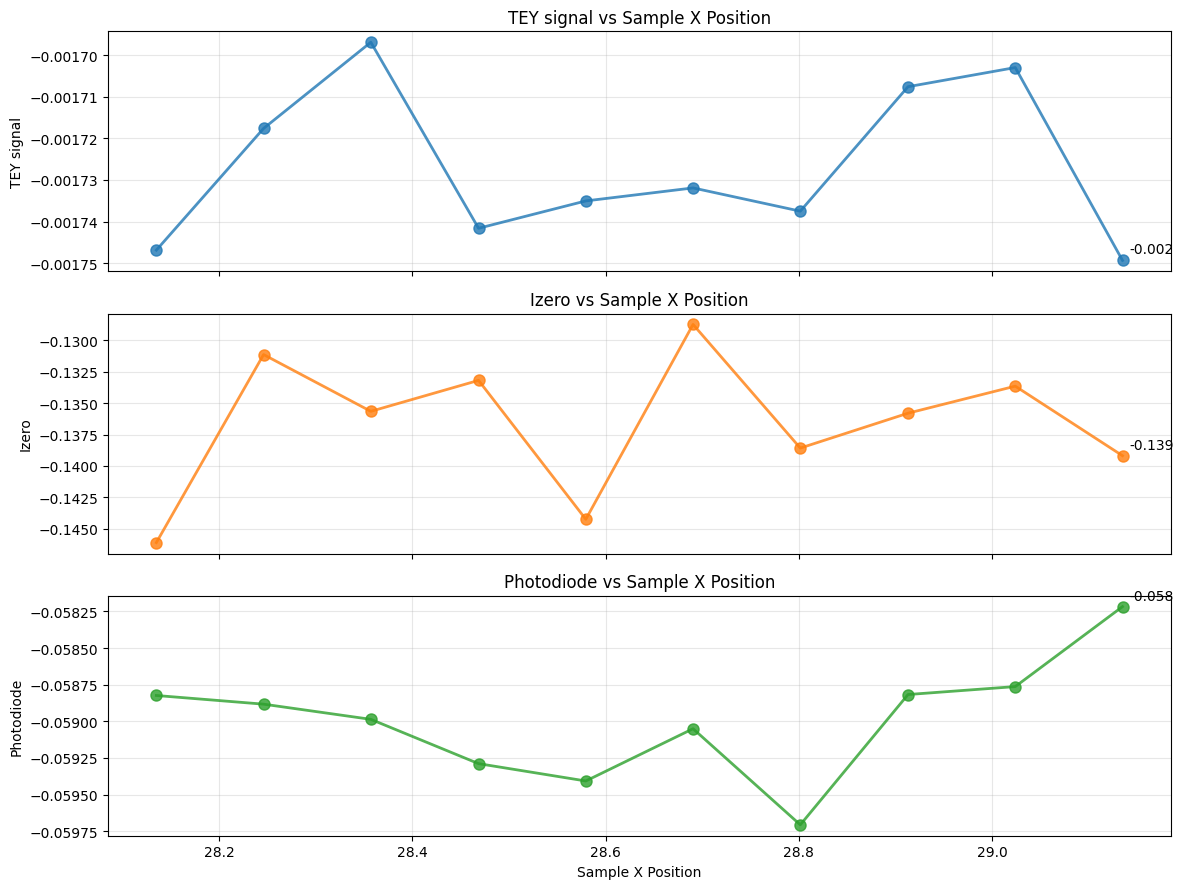

Position: 29.1350, AI values: ['-0.002', '-0.139', '-0.058']
--------------------------------------------------
Returning to initial position: 28.135
  ✓ Motor Sample X reached position: 28.1350
  ✓ Motor Sample X reached position: 28.1350

=== Final Results ===

=== Final Results ===


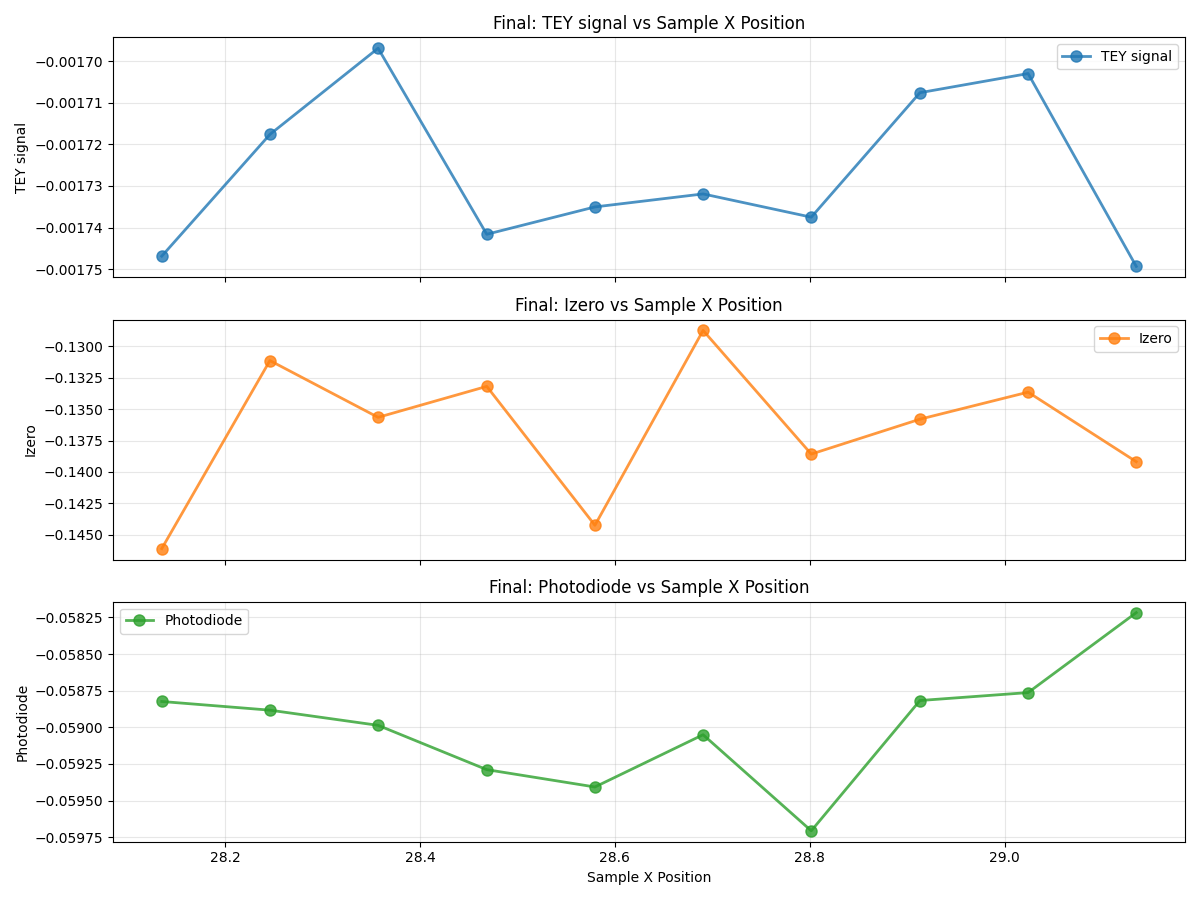


=== Positioning Accuracy Summary ===
Max position error: 0.0002
RMS position error: 0.0001


In [ ]:
# Option 1: Simple real-time plotting (recreates plot each step)
print("=== Option 1: Simple Real-time Plotting ===")
scan_data = await safe_motor_scan_with_realtime_plot(
    motor_name="Sample X",
    ai_channels=["TEY signal", "Izero", "Photodiode"],
    scan_range=1,  # Very small range for safety
    num_steps=10,
    delay_between_steps=0.1,
)

In [ ]:
# ======================================
# HIGH-LEVEL SCANNING INTERFACE
# ======================================

from dataclasses import dataclass
from typing import Callable, Optional


@dataclass
class ScanPoint:
    """Data structure for a single scan point."""

    step: int
    target_position: float
    actual_position: float
    position_error: float
    ai_values: dict[str, float]
    timestamp: float
    metadata: dict = None


class MotorScanner:
    """
    High-level interface for motor scanning with real-time data processing.
    Separates scanning logic from plotting and provides data processing hooks.
    """

    def __init__(self, rsoxs_server):
        self.rsoxs = rsoxs_server
        self.scan_data = []
        self.data_processors = []  # List of real-time data processing functions

    def add_data_processor(self, processor_func: Callable[[ScanPoint], Any]):
        """
        Add a real-time data processing function.

        Parameters:
            processor_func: Function that takes a ScanPoint and returns processed data
        """
        self.data_processors.append(processor_func)

    def clear_processors(self):
        """Clear all data processors."""
        self.data_processors.clear()

    async def scan_motor(
        self,
        motor_name: Motor,
        start_position: Optional[float] = None,
        scan_range: float = 0.1,
        num_steps: int = 10,
        ai_channels: list[AI] = ["TEY signal", "Izero", "Photodiode"],
        delay_between_steps: float = 0.5,
        move_timeout: float = 30.0,
        return_to_start: bool = True,
        confirm_scan: bool = True,
    ) -> list[ScanPoint]:
        """
        Execute a motor scan and return structured data.

        Parameters:
            motor_name: Name of the motor to scan
            start_position: Starting position (None = current position)
            scan_range: Total scan range
            num_steps: Number of scan steps
            ai_channels: List of AI channels to monitor
            delay_between_steps: Settling time after each move
            move_timeout: Maximum time to wait for motor moves
            return_to_start: Whether to return to starting position
            confirm_scan: Whether to ask for user confirmation

        Returns:
            List of ScanPoint objects containing all scan data
        """

        # Get initial position
        if start_position is None:
            initial_motor_data = await self.rsoxs.get_motor(motors=[motor_name])
            start_position = initial_motor_data["data"][0]["position"]

        print("=== Motor Scan Configuration ===")
        print(f"Motor: {motor_name}")
        print(f"Start Position: {start_position:.4f}")
        print(f"Scan Range: {scan_range:.4f}")
        print(f"End Position: {start_position + scan_range:.4f}")
        print(f"Number of Steps: {num_steps}")
        print(f"AI Channels: {ai_channels}")
        print(f"Delay Between Steps: {delay_between_steps}s")

        # Safety confirmation
        if confirm_scan:
            response = input("Proceed with scan? (y/N): ")
            if response.lower() != "y":
                print("Scan cancelled.")
                return []

        # Calculate scan positions
        scan_positions = [
            start_position + (scan_range * i / (num_steps - 1))
            for i in range(num_steps)
        ]

        # Initialize scan data storage
        self.scan_data = []

        try:
            print("\n=== Starting Scan ===")

            for i, target_position in enumerate(scan_positions):
                step_start_time = time.time()

                print(f"Step {i + 1}/{num_steps}: Moving to {target_position:.4f}")

                # Move motor
                await self.rsoxs.command_motor(
                    commands=["Backlash Move"],
                    motors=[motor_name],
                    goals=[target_position],
                )

                # Wait for completion
                move_success = await wait_for_motor_completion(motor_name, move_timeout)
                if not move_success:
                    print("  ⚠️ Move may not have completed")

                # Settling time
                if delay_between_steps > 0:
                    await asyncio.sleep(delay_between_steps)

                # Get actual position
                current_motor_data = await self.rsoxs.get_motor(motors=[motor_name])
                actual_position = current_motor_data["data"][0]["position"]
                position_error = abs(target_position - actual_position)

                # Get AI data
                ai_values = {}
                try:
                    freerun_data = await self.rsoxs.get_freerun_array()
                    channel_data = process_channels(freerun_data)

                    for channel in ai_channels:
                        ai_values[channel] = safe_extract_ai_value(
                            channel_data, channel
                        )

                except Exception as e:
                    print(f"  Warning: Error getting AI data: {e}")
                    for channel in ai_channels:
                        ai_values[channel] = 0.0

                # Create scan point
                scan_point = ScanPoint(
                    step=i + 1,
                    target_position=target_position,
                    actual_position=actual_position,
                    position_error=position_error,
                    ai_values=ai_values,
                    timestamp=time.time(),
                    metadata={"motor_name": motor_name},
                )

                # Store data
                self.scan_data.append(scan_point)

                # Run real-time data processors
                for processor in self.data_processors:
                    try:
                        processor(scan_point)
                    except Exception as e:
                        print(f"  Warning: Data processor error: {e}")

                # Progress report
                print(f"  ✓ Actual: {actual_position:.4f}, Error: {position_error:.4f}")
                print(
                    f"  AI Values: {', '.join([f'{ch}: {val:.3f}' for ch, val in ai_values.items()])}"
                )

        except Exception as e:
            print(f"Error during scan: {e}")
            import traceback

            traceback.print_exc()

        finally:
            # Return to start position
            if return_to_start:
                print(f"\nReturning to start position: {start_position:.4f}")
                await self.rsoxs.command_motor(
                    commands=["Backlash Move"],
                    motors=[motor_name],
                    goals=[start_position],
                )
                await wait_for_motor_completion(motor_name, move_timeout)

        print("\n=== Scan Complete ===")
        print(f"Collected {len(self.scan_data)} data points")

        return self.scan_data

    def get_scan_arrays(self) -> dict:
        """
        Extract scan data as numpy arrays for easy analysis.

        Returns:
            Dictionary with arrays for positions, AI channels, etc.
        """
        if not self.scan_data:
            return {}

        arrays = {
            "steps": np.array([point.step for point in self.scan_data]),
            "target_positions": np.array(
                [point.target_position for point in self.scan_data]
            ),
            "actual_positions": np.array(
                [point.actual_position for point in self.scan_data]
            ),
            "position_errors": np.array(
                [point.position_error for point in self.scan_data]
            ),
            "timestamps": np.array([point.timestamp for point in self.scan_data]),
        }

        # Extract AI channels
        if self.scan_data:
            ai_channels = list(self.scan_data[0].ai_values.keys())
            for channel in ai_channels:
                arrays[channel] = np.array(
                    [point.ai_values[channel] for point in self.scan_data]
                )

        return arrays


class ScanPlotter:
    """
    Separate plotting class for visualizing scan data.
    """

    @staticmethod
    def plot_scan_results(scan_data: list[ScanPoint], ai_channels: list[str] = None):
        """
        Plot scan results with multiple AI channels.

        Parameters:
            scan_data: List of ScanPoint objects
            ai_channels: Specific channels to plot (None = all channels)
        """
        if not scan_data:
            print("No scan data to plot")
            return

        # Extract data
        positions = [point.actual_position for point in scan_data]

        # Determine channels to plot
        if ai_channels is None:
            ai_channels = list(scan_data[0].ai_values.keys())

        # Create subplots
        fig, axes = plt.subplots(
            len(ai_channels), 1, figsize=(12, 3 * len(ai_channels)), sharex=True
        )
        if len(ai_channels) == 1:
            axes = [axes]

        # Plot each channel
        for i, channel in enumerate(ai_channels):
            values = [point.ai_values.get(channel, 0) for point in scan_data]

            axes[i].plot(
                positions, values, "o-", linewidth=2, markersize=8, label=channel
            )
            axes[i].set_ylabel(channel)
            axes[i].grid(True, alpha=0.4)
            axes[i].set_title(f"{channel} vs Position")
            axes[i].legend()

        axes[-1].set_xlabel("Motor Position")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_positioning_accuracy(scan_data: list[ScanPoint]):
        """Plot positioning accuracy analysis."""
        if not scan_data:
            return

        targets = [point.target_position for point in scan_data]
        actuals = [point.actual_position for point in scan_data]
        errors = [point.position_error for point in scan_data]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

        # Target vs Actual
        ax1.plot(targets, actuals, "o-", label="Actual Position")
        ax1.plot(targets, targets, "--", alpha=0.7, label="Target Position")
        ax1.set_xlabel("Target Position")
        ax1.set_ylabel("Actual Position")
        ax1.set_title("Target vs Actual Position")
        ax1.legend()
        ax1.grid(True, alpha=0.4)

        # Position errors
        ax2.plot(targets, errors, "ro-", label="Position Error")
        ax2.set_xlabel("Target Position")
        ax2.set_ylabel("Position Error")
        ax2.set_title("Positioning Accuracy")
        ax2.legend()
        ax2.grid(True, alpha=0.4)

        plt.tight_layout()
        plt.show()


# ======================================
# REAL-TIME DATA PROCESSING EXAMPLES
# ======================================


def create_realtime_plotter(ai_channels: list[str]) -> Callable:
    """
    Create a real-time plotting function.

    Parameters:
        ai_channels: List of AI channels to plot

    Returns:
        Function that can be used as a data processor
    """
    positions = []
    ai_data = {channel: [] for channel in ai_channels}

    def realtime_plot(scan_point: ScanPoint):
        # Update data
        positions.append(scan_point.actual_position)
        for channel in ai_channels:
            ai_data[channel].append(scan_point.ai_values.get(channel, 0))

        # Clear and replot
        clear_output(wait=True)

        fig, axes = plt.subplots(
            len(ai_channels), 1, figsize=(10, 2.5 * len(ai_channels)), sharex=True
        )
        if len(ai_channels) == 1:
            axes = [axes]

        for i, channel in enumerate(ai_channels):
            axes[i].plot(positions, ai_data[channel], "o-", linewidth=2, markersize=6)
            axes[i].set_ylabel(channel)
            axes[i].set_title(f"{channel} vs Position")
            axes[i].grid(True, alpha=0.4)

            # Annotate current value
            if positions:
                axes[i].annotate(
                    f"{ai_data[channel][-1]:.3f}",
                    xy=(positions[-1], ai_data[channel][-1]),
                    xytext=(5, 5),
                    textcoords="offset points",
                )

        axes[-1].set_xlabel("Motor Position")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

    return realtime_plot


def create_math_processor(formula: str, channels: list[str]) -> Callable:
    """
    Create a real-time math processor.

    Parameters:
        formula: Mathematical formula as string (e.g., "TEY signal / Izero")
        channels: List of channel names used in the formula

    Returns:
        Function that calculates and prints the result
    """

    def math_processor(scan_point: ScanPoint):
        try:
            # Create local variables for the formula
            local_vars = {}
            for channel in channels:
                # Replace spaces and special characters for variable names
                var_name = channel.replace(" ", "_").replace("-", "_")
                local_vars[var_name] = scan_point.ai_values.get(channel, 0)

            # Evaluate formula
            # Convert formula to use variable names
            eval_formula = formula
            for channel in channels:
                var_name = channel.replace(" ", "_").replace("-", "_")
                eval_formula = eval_formula.replace(channel, var_name)

            # Set up the environment for eval, including numpy
            eval_globals = {"__builtins__": {}, "np": np}

            result = eval(eval_formula, eval_globals, local_vars)
            print(f"  Math Result: {formula} = {result:.6f}")

        except Exception as e:
            print(f"  Math Error: {e}")

    return math_processor


# ======================================
# EXAMPLE USAGE
# ======================================

# Create scanner instance
scanner = MotorScanner(rsoxs)

# Example: Add real-time plotting
realtime_plotter = create_realtime_plotter(["TEY signal", "Izero", "Photodiode"])
scanner.add_data_processor(realtime_plotter)

# Example: Add real-time math processing
math_processor = create_math_processor("TEY_signal / Izero", ["TEY signal", "Izero"])
scanner.add_data_processor(math_processor)

High-level scanning interface ready!

Example usage:
# Perform a scan
scan_results = await scanner.scan_motor('Sample X', scan_range=0.1, num_steps=10)

# Plot results
ScanPlotter.plot_scan_results(scan_results)

# Get arrays for analysis
arrays = scanner.get_scan_arrays()
print(f'TEY/Izero ratio: {arrays["TEY signal"] / arrays["Izero"]}')


=== Motor Scan Configuration ===
Motor: Sample X
Start Position: 28.1350
Scan Range: 1.0000
End Position: 29.1350
Number of Steps: 10
AI Channels: ['TEY signal', 'Izero', 'Photodiode']
Delay Between Steps: 0.5s

=== Starting Scan ===
Step 1/10: Moving to 28.1350

=== Starting Scan ===
Step 1/10: Moving to 28.1350
  ✓ Motor Sample X reached position: 28.1350
  ✓ Motor Sample X reached position: 28.1350
  ✓ Actual: 28.1350, Error: 0.0000
  AI Values: TEY signal: -0.002, Izero: -0.123, Photodiode: -0.059
Step 2/10: Moving to 28.2461
  ✓ Actual: 28.1350, Error: 0.0000
  AI Values: TEY signal: -0.002, Izero: -0.123, Photodiode: -0.059
Step 2/10: Moving to 28.2461
  ✓ Motor Sample X reached position: 28.2460
  ✓ Motor Sample X reached position: 28.2460
  ✓ Actual: 28.2460, Error: 0.0001
  AI Values: TEY signal: -0.002, Izero: -0.131, Photodiode: -0.058
Step 3/10: Moving to 28.3572
  ✓ Actual: 28.2460, Error: 0.0001
  AI Values: TEY signal: -0.002, Izero: -0.131, Photodiode: -0.058
Step 3/10:

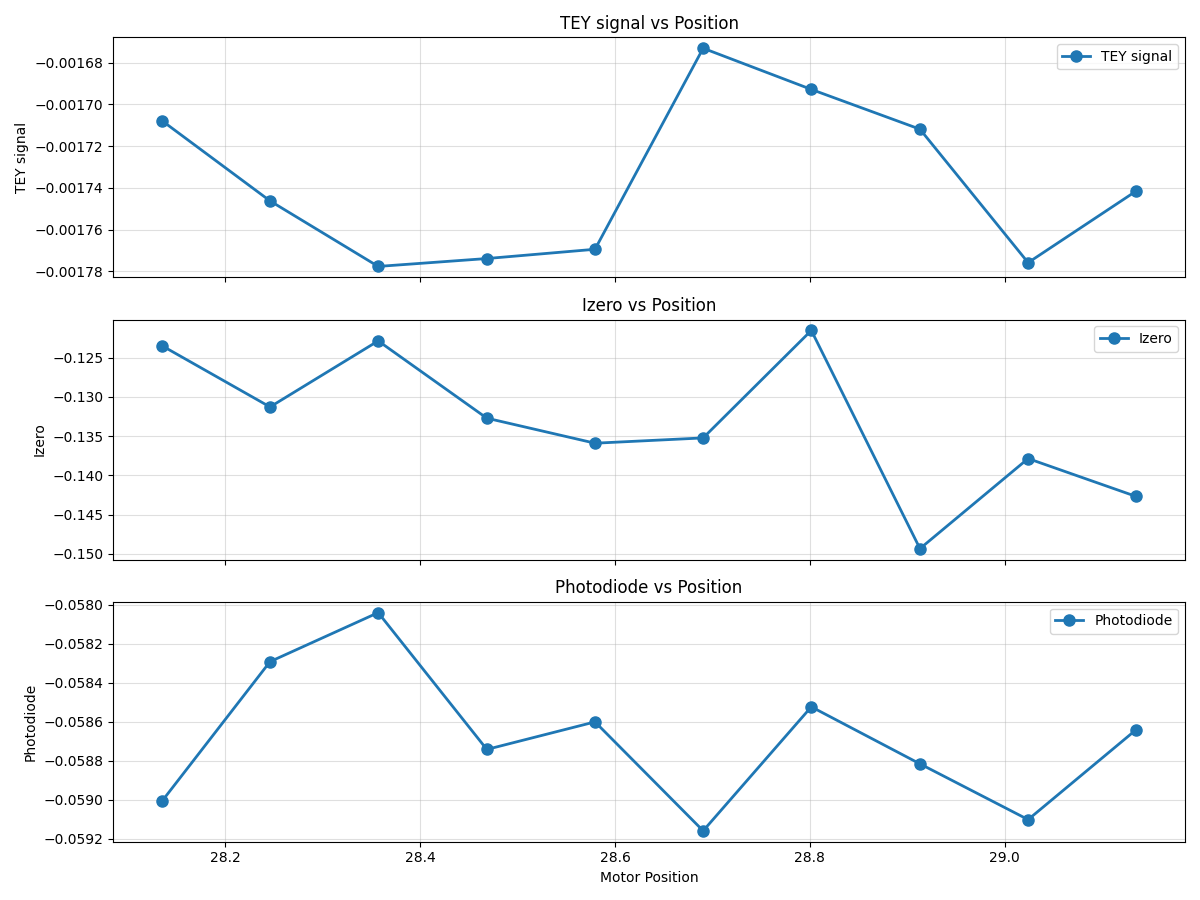

In [ ]:
# Simple scan
scanner = MotorScanner(rsoxs)
results = await scanner.scan_motor("Sample X", scan_range=1, num_steps=10)

# Plot results
ScanPlotter.plot_scan_results(results)

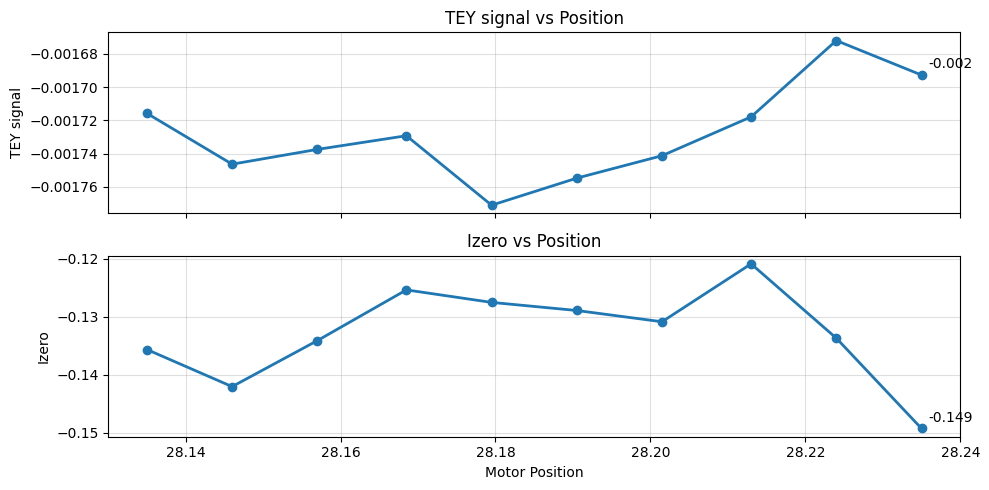

  Math Result: TEY_signal / Izero = 0.011339
  ✓ Actual: 28.2350, Error: 0.0000
  AI Values: TEY signal: -0.002, Izero: -0.149, Photodiode: -0.059

Returning to start position: 28.1350
  ✓ Motor Sample X reached position: 28.1350

=== Scan Complete ===
Collected 10 data points
  ✓ Motor Sample X reached position: 28.1350

=== Scan Complete ===
Collected 10 data points


In [ ]:
# Add real-time plotting
realtime_plotter = create_realtime_plotter(["TEY signal", "Izero"])
scanner.add_data_processor(realtime_plotter)

# Add real-time math
math_processor = create_math_processor("TEY_signal / Izero", ["TEY signal", "Izero"])
scanner.add_data_processor(math_processor)

# Now scan with live processing
results = await scanner.scan_motor(
    "Beamline Energy", scan_range=0.1, num_steps=10, delay_between_steps=0.01
)

In [ ]:
# Get structured arrays
arrays = scanner.get_scan_arrays()

# Mathematical analysis
tey_izero_ratio = arrays["TEY signal"] / arrays["Izero"]
#  Drop negative or zero values to avoid log issues

# Custom calculations
signal_to_noise = arrays["TEY signal"] / np.std(arrays["TEY signal"])

#  Plot absorption and signal-to-noise
plt.figure(figsize=(10, 5))
plt.plot(arrays["actual_positions"], absorption, label="Absorption (-ln(TEY))")
plt.plot(arrays["actual_positions"], signal_to_noise, label="Signal-to-Noise Ratio")
plt.xlabel("Motor Position")
plt.legend()

ValueError: zero-size array to reduction operation maximum which has no identity